In [1]:
import torch
from torch import nn
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# plt.style.use('dark_background')

from modules import ELBO
from utils import load_sim_data

### Setup parameters

In [2]:
N = 11
sim_curvature = 30 # simulated average curvature (in degrees)
out_dict = "/Users/nguyentiendung/GitHub/perceptual-straightening/model/"
data_path = "/Users/nguyentiendung/GitHub/perceptual-straightening/data/simulations/"

### Run inference

In [28]:
glob_curv = 90 * (np.pi / 180) # in rad
model = ELBO(N, data_path, glob_curv)

lr = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
model_file = Path(out_dict) / f'model_{sim_curvature}.pt'

#### Pre-train optimizer by only optimizing KL-divergence first (find a good initialization)

In [4]:
# iterations = 10000
# kl_loss = np.zeros(iterations)

# for i in range(iterations):
#     kl = model.kl_divergence()
#     kl.backward()
#     optimizer.step()
#     optimizer.zero_grad()

#     kl_loss[i] = kl.item()

#     if not i % 1000:
#         print(f"Epoch: {i}, Loss: {kl.item()}")

In [23]:
# plt.plot(kl_loss, color='orange')
# plt.title('KL-divergence loss')
# plt.xlabel('Iteration')
# plt.ylabel('KL-divergence')
# plt.show()

#### Optimize the whole ELBO

In [29]:
iterations = 10000

# errors
errors = np.zeros(iterations)
kl_loss = np.zeros(iterations)
ll_loss = np.zeros(iterations)

# variables
mus = np.zeros(iterations)
ds = np.zeros(iterations)

best_iteration = 0
for i in range(iterations):
    log_ll, d, c, a = model.compute_likelihood()
    kl = model.kl_divergence()
    loss = model.compute_loss(log_ll, kl)

    # gradient update
    loss.backward()
    # for name, param in model.named_parameters():
    #     print(f"{name}: grad={param.grad}")

    optimizer.step()
    optimizer.zero_grad()

    # store errors for each iteration
    errors[i] = loss.item()
    kl_loss[i] = kl.item()
    ll_loss[i] = log_ll.item()
    mus[i] = model.mu_c.detach().numpy()[0] * (180 / np.pi)
    ds[i] = model.mu_d.detach().numpy()[0]

    # save best model but exclude the ones whose errors are below 0
    if errors[i] <= errors[best_iteration] and (not errors[i] < 0):
        d_best = d
        c_best = c
        a_best = a
        torch.save(model.state_dict(), model_file)
        best_iteration = i

    # print progress
    if not i % 5:
        print(f"Epoch: {i}, Loss: {loss.item()}")

    # stop when error becomes too negative
    if errors[i] < -20: 
        errors = errors[:i+1]
        kl_loss = kl_loss[:i+1]
        ll_loss = ll_loss[:i+1]
        mus = mus[:i+1]
        ds = ds[:i+1]
        break

print(f'Best epoch: {best_iteration}, Loss: {errors[best_iteration]}')

# save parameters
phi_params = {'d': d_best,
              'c': c_best,
              'a': a_best}
torch.save(phi_params, Path(data_path) / f'params_{sim_curvature}.pt')

Epoch: 0, Loss: 464.4962158203125
Epoch: 5, Loss: 413.11260986328125
Epoch: 10, Loss: 386.56451416015625
Epoch: 15, Loss: 314.2768859863281
Epoch: 20, Loss: 307.78240966796875
Epoch: 25, Loss: 258.75775146484375
Epoch: 30, Loss: 216.53343200683594
Epoch: 35, Loss: 247.44732666015625
Epoch: 40, Loss: 209.897705078125
Epoch: 45, Loss: 199.7140655517578
Epoch: 50, Loss: 206.02880859375
Epoch: 55, Loss: 205.06784057617188
Epoch: 60, Loss: 157.64044189453125
Epoch: 65, Loss: 100.27395629882812
Best epoch: 67, Loss: 66.177490234375


In [17]:
# for name, param in model.named_parameters():
#     print(f"{name}: is_leaf={param.is_leaf}, requires_grad={param.requires_grad}")

#### Load final model and plot error curves

In [8]:
best_model = ELBO(N, data_path, glob_curv)
best_model.load_state_dict(torch.load(model_file, weights_only=True))

<All keys matched successfully>

/opt/anaconda3/envs/vision/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


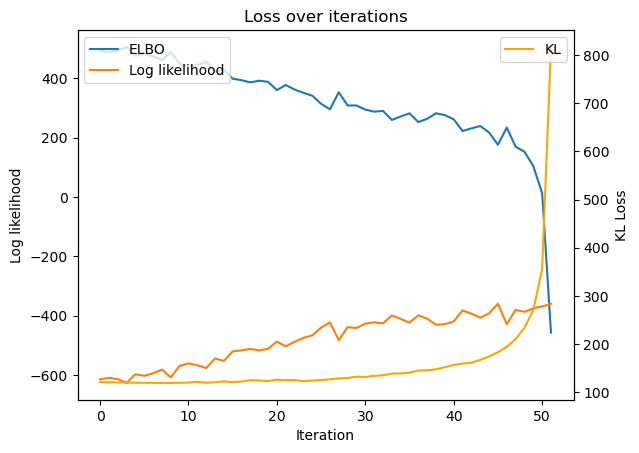

In [9]:
fig, ax1 = plt.subplots()

# Primary y-axis (ELBO and Neg. log likelihood)
ax1.plot(errors, label='ELBO')
ax1.plot(ll_loss, label='Log likelihood')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Log likelihood')
ax1.tick_params(axis='y')

# Add title
plt.title('Loss over iterations')

# Create a secondary y-axis for KL loss
ax2 = ax1.twinx()
ax2.plot(kl_loss, label='KL', color='orange')
ax2.set_ylabel('KL Loss')
ax2.tick_params(axis='y')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# save and show the plot
plt.savefig(Path(out_dict) / f"error_{sim_curvature}")
plt.show()

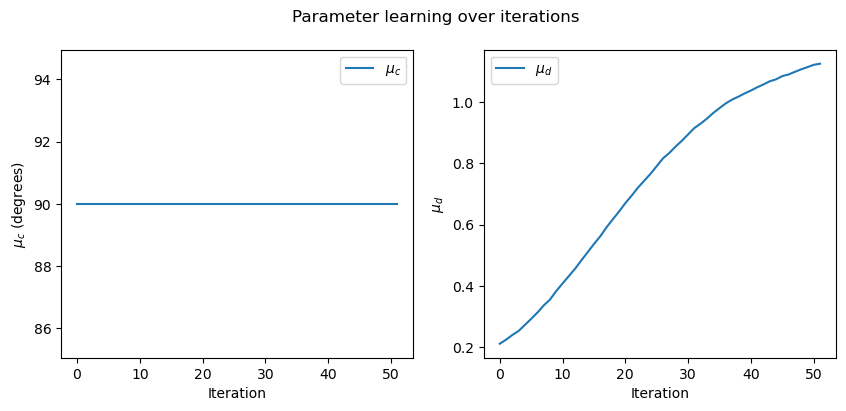

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(mus, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(ds, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

for i in range(2):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations')
plt.show()

### Reconstruct trajectory

In [11]:
est_global_curvature = best_model.mu_c.detach().numpy() * (180 / np.pi)
print(f'Estimated global curvature: {est_global_curvature[0]} degrees')
print(f'Average estimated local curvature: {torch.mean(c_best).detach().numpy() * (180/np.pi)} degrees')

Estimated global curvature: 90.0 degrees
Average estimated local curvature: 88.8723519328874 degrees


In [12]:
def run_pca(X, n_components=2):
    """
    Run PCA on the estimated trajectory. 

    Inputs:
    -------
    X: (n_dimensions x n_frames) torch tensor
        Input matrix (estimated trajectory)
    n_components: Scalar
        Number of fitted principle components

    Output:
    -------
    X_new: (n_frames x n_components) numpy array
        Transformed values
    """
    
    pca = PCA(n_components)
    pca.fit(X)
    return pca.components_

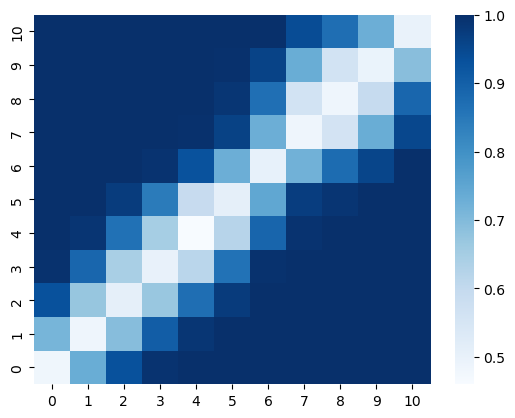

In [13]:
# load simulated data
discrim_mat = torch.from_numpy(scipy.io.loadmat(Path(data_path) / 'discriminality_matrix.mat')['Pc_reshaped'])

# plot data
ax = sns.heatmap(discrim_mat, cmap='Blues')
ax.invert_yaxis()
plt.show()

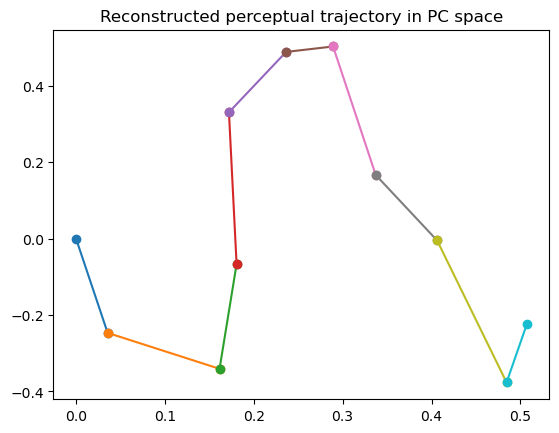

In [14]:
# run PCA to reduce the dimensionality of the trajectory
x = torch.squeeze(best_model.construct_trajectory(torch.mean(d_best, dim=0, keepdim=True), 
                               torch.mean(c_best, dim=0, keepdim=True), 
                               torch.mean(a_best, dim=0, keepdim=True)))

pc = run_pca(x.t().detach().numpy())
for i in range(pc.shape[1]-1):
    plt.plot([pc[0, i], pc[0, i+1]], [pc[1, i], pc[1, i+1]], '-o')
plt.title('Reconstructed perceptual trajectory in PC space')
plt.show()

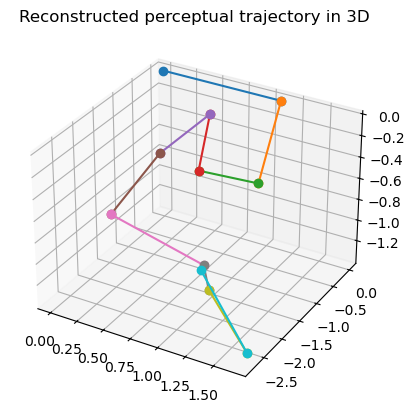

In [15]:
# visualize the perceptual trajectory for >= 3d (plotting first 3 dimensions)
x_np = x.detach().numpy().T
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(pc.shape[1]-1):
    plt.plot([x_np[0, i], x_np[0, i+1]], 
             [x_np[1, i], x_np[1, i+1]],
             [x_np[2, i], x_np[2, i+1]], '-o')
plt.title('Reconstructed perceptual trajectory in 3D')
plt.show()

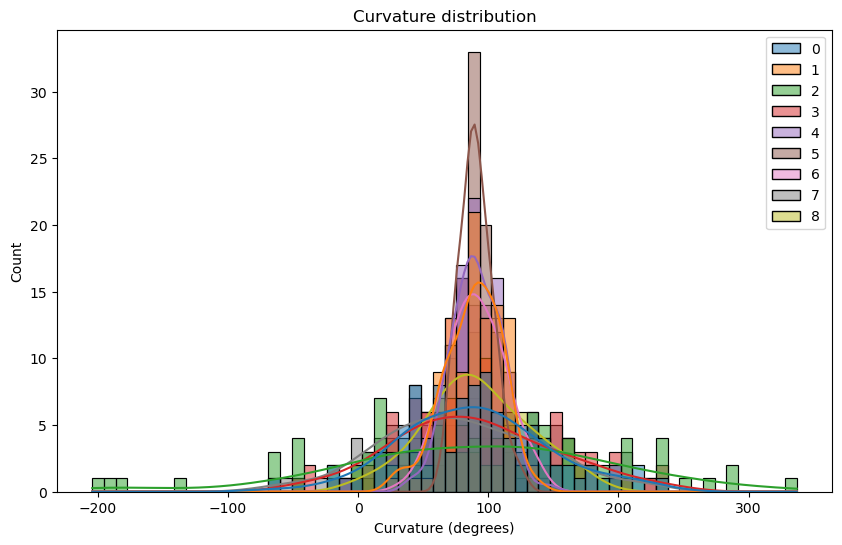

In [16]:
# plot histograms of trajectory variables
fig, axs = plt.subplots(figsize=(10, 6))
sns.histplot(c_best.detach().numpy() * (180 / np.pi), kde=True, ax=axs)
axs.set_xlabel('Curvature (degrees)')
axs.set_title('Curvature distribution')
plt.show()